Project 4: Natural Language Processing and Unsupervised Learning

In this notebook, I do topic modeling on my reddit r/medicine 2020 post data. I topic model on all the posts to get a general sense for what topics are being talked about. I also topic model on all posts per month to see how trends in topics have shifted over time.<br/>

Additionally, I do sentiment analysis on the posts by topic as well.

# Table of Contents
1. [Imports](#section1)
2. [Getting Post Data from SQL Database](#section2)
3. [NLP Pipeline](#section3)
4. [Topic Modeling on All Posts](#section4)
5. [Topic Modeling on Monthly Posts](#section5)
6. [Sentiment Analysis by Topic](#section6)

<a id='section1'></a>

### 1. Imports

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# imports for accessing SQL database
import psycopg2 as pg

# NLP preprocessing
import re
import string

from nltk.corpus import stopwords
from nltk.help import upenn_tagset
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy

# Topic Modeling
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim

# Sentiment Analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

<a id='section2'></a>

### 2. Getting Post Data from SQL Database

Before I can start topic modeling, I need to get my saved reddit data.

In [4]:
# Postgres info to connect
connection_args = {
                   'host': 'localhost', # we are connecting to our local version of psql
                   'dbname': 'reddit_medicine', # DB we are connecting to
                   'port': 5432, # port we opened
                   'password': '',
                   'user': 'postgres'
                   }

In [5]:
def connect_to_postgres(connection_args):
    '''
    Connect to PostgreSQL database
    Parameters:
    -----------
    - connection_args: parameters to connect to psql db
    Returns:
    --------
    - connection: connection to the psql db
    '''
    connection = None
    try:
        connection = pg.connect(**connection_args)
    except (Exception, pg.DatabaseError) as error:
        print(error)
    
    return connection

In [6]:
connection = connect_to_postgres(connection_args)

In [7]:
# exclude megathreads with repetitive post titles and submissions
reddit_query = "SELECT * FROM submissions \
                WHERE title NOT LIKE 'Megathread:%' \
                AND title NOT LIKE 'Megathread #%' \
                AND title NOT LIKE 'Weekly Careers Thread';"

reddit_df = pd.read_sql(reddit_query, connection)
connection.close()

In [8]:
reddit_df["full_text"] = reddit_df["title"] + ' ' + reddit_df["submission_text"]

In [9]:
print(reddit_df.shape)

(1349, 11)


My reddit_df DataFrame originally has 1400 rows because I collected the top 200 posts from reddit r/medicine for each month of 2020 from January to July. Thus, there are 200 posts from January, 200 posts from February, etc. <br/>

However, because I am excluding the megathreads and careers thread, I am reducing the total amount of posts in my dataframe from 1400 to 1349.

<a id='section3'></a>

### 3. NLP Pipeline

First, I build a class to make a reusable NLP pipeline. I'll be trying out different preprocessing techniques to see how that affects topic modeling, so this will be immensely helpful in testing out different models.

In [11]:
class NLP_Preprocessor:
    '''
    A class for pipelining NLP data. The user provides text, and this class
    cleans, transforms, and does other modifications of the data in preparation
    for topic modeling.
    
    Parameters:
    -----------
    - vectorizer: how the text data is vectorized
    - tokenizer: tokenize to use; defaults to splitting on spaces
    - cleaning_function: function to clean the data
    - lemmatizer: function to lemmatize the text (note: decided on lemmatizers over stemmers for interpretability)
    - pos_function: function to clean data based on part of speech
    - pos_filter: list of part of speech abbreviations to filter on (based on spacy's POS abbreviations)
    - spacy_nlp: the spacy NLP instance
    - model: the model to fit and transform the cleaned text on
    - n_word: the number of words to output when displaying topics
    '''
    
    def __init__(self, 
                 vectorizer=CountVectorizer(),
                 tokenizer=None,
                 cleaning_function=None,
                 lemmatizer_function=None,
                 pos_function = None,
                 pos_filter = None,
                 spacy_nlp = None,
                 model=None,
                 n_words = 5):

        self._default_clean = False
        
        if not tokenizer:
            tokenizer = self.splitter
        if not cleaning_function:
            cleaning_function = self.clean_text
            self._default_clean = True
            
        self.vectorizer = vectorizer
        self.tokenizer = tokenizer
        self.cleaning_function = cleaning_function
        self.lemmatizer_function = lemmatizer_function
        self.pos_function = pos_function
        self.pos_filter = pos_filter
        self.spacy_nlp = spacy_nlp
        self.model = model
        self.n_words = n_words # default number of words to show per topic is five
        self._is_fit = False
        self.vectorized_text = ''
        
    def splitter(self, text):
        '''
        Default tokenizer that splits on spaces
        '''
        return text.split(' ')
    
    def clean_text(self, text, tokenizer, stemmer):
        '''
        Naive function to lowercase all words and clean them
        quickly. This is the default if no other cleaning
        function is specified
        '''
        cleaned_text = []
        
        for post in text:
            cleaned_words = []
            for word in tokenizer(post):
                lower_word = word.lower()
                if stemmer:
                    lower_word = stemmer.stem(lower_word)
                cleaned_words.append(lower_word)
            cleaned_text.append(' '.join(cleaned_words))
        return cleaned_text
    
    def fit(self, text):
        '''
        Cleans the data and fits the vectorizer to the text.
        '''
        
        if self._default_clean:
            clean_text = self.cleaning_function(text, self.tokenizer, self.stemmer)
        else:
            clean_text = self.cleaning_function(text, regex_patterns, char_space, char_no_space, abbrev_dict)

        if self.pos_function:
            clean_text = self.pos_function(clean_text, self.pos_filter, self.spacy_nlp)

        if self.lemmatizer_function:
            clean_text = self.lemmatizer_function(clean_text)
        
        self.vectorizer.fit(clean_text)
        
        self._is_fit = True


    def transform(self, text):
        '''
        Cleans the data, and transforms it into a vectorized format.
        '''
        
        if not self._is_fit:
            raise ValueError("Must fit model before transforming!")
        
        if self._default_clean:
            clean_text = self.cleaning_function(text, self.tokenizer, self.stemmer)
        else:
            clean_text = self.cleaning_function(text, regex_patterns, char_space, char_no_space, abbrev_dict)
        
        if self.pos_function:
            clean_text = self.pos_function(clean_text, self.pos_filter, self.spacy_nlp)

        if self.lemmatizer_function:
            clean_text = self.lemmatizer_function(clean_text)
        
        self.vectorized_text = self.vectorizer.transform(clean_text)
    
    def display_topics(self):
        '''
        Displays topics given by the model.
        '''
        
        if not self._is_fit:
            raise ValueError("Must fit and transform text to vectorizer before displaying topics")
        
        doc_topic = self.model.fit_transform(self.vectorized_text)
        
        for ix, topic in enumerate(self.model.components_):
            topic_words = [self.vectorizer.get_feature_names()[i] for i in topic.argsort()[:-self.n_words - 1:-1]]
            print("\nTopic: ", ix)
            print(", ".join(topic_words))
   

Cleaning function to remove certain regex patterns as well as characters that need to be replaced with a space (general punctuation) or not a space(hyphens, slashes). Additionally, spell out some abbreviations.

In [12]:
def my_cleaning_function(text, regex_patterns, char_space, char_no_space, abbrev_dict):
    '''
    With this cleaning function, I clean up my text by removing certain regex patterns like hyperlinks, replacing certain
    punctuation with spaces or no spaces, and spelling out important abbreviations.
    
    Parameters:
    -----------
    - text (string): string of reddit posts
    - regex_patterns (list): list of regex patterns to remove
    - char_space (string): characters to replace with a space
    - char_no_space (string): characters to replace with no space
    - abbrev_dict (dict): dictionary to replace abbreviations with full words
    
    Returns:
    --------
    - cleaned_text (string): cleaned string of reddit posts
    '''
    
    cleaned_text = []
    
    for post in text:
        
        for pattern in regex_patterns:
            post = re.sub(pattern, ' ', post)
    
        for char in char_space:
            post = post.replace(char, ' ')
    
        for char in char_no_space:
            post = post.replace(char, '')
        
        for key in abbrev_dict.keys():
            post = post.replace(key, ' ' + abbrev_dict[key] + ' ')
    
        post = post.lower()
        post.replace('  ', ' ') # replace extra spaces with one space
        
        cleaned_text.append(post)
    
    return cleaned_text

In [13]:
# List of regex patterns, characters, and abbreviations to clean my text with
regex_patterns = ['\n', '\t', r'https?:\/\/\S+', r'&\S*', r'\\xa0', r'[__]{2,}', r'[\d]+', 'χ', '®']
char_space = '^*>|[]()",°#'
char_no_space = '/-\\'
abbrev_dict = {"MD": "doctor_of_medicine",
               "MPH": "master_of_public_health",
               "MBA": "master_of_business_administrationi",
               "NP": "nurse_practitioner",
               "PA": "physician_assistant",
               "RN": "registered_nurse",
               "DVM": "doctor_of_veterinary_medicine",
               "DDS": "doctor_of_dentistry",
               "DO": "doctor_of_osteopathy",
               "ICU": "intensive_care_unit",
               "ER": "emergency_room",
               "ED": "emergency_department",
               "EMS": "emergency_medical_services",
               "EMR": "electronic_medical_records",
               "CFR": "case_fatality_rate",
               "CT": "computed_tomography",
               "CDC": "centers_for_disease_control",
               "WHO": "world_health_organization",
               "FDA": "food_and_drug_administration",
               "SARS": "severe_acute_respiratory_syndrome",
               "MERS": "middle_east_respiratory_syndrome",
               "ARDS": "acute_respiratory_distress_syndrome",
               "SOM": "school_of_medicine",
               "COVID": "covid", # make sure the word covid is distinct
               "N95": "n_ninety_fifty", # make sure n-95 masks are distinct words
               "PPE": "personal_protective_equipment"
               }

In [14]:
def spacy_lemmatizer(text):
    '''
    Function to lemmatize text using spacy nlp model.
    
    Parameters:
    -----------
    - text (list of strings): text to lemmatize
    
    Returns:
    -------
    - Returns a list of strings where each word in each string has been lemmatized
    
    '''
    lemmatize_post_list = []
    spacy_nlp = spacy.load("en_core_web_sm")
    
    for post in text:
    
        doc = spacy_nlp(post)
        lemmatize_word_list = []
        
        for token in doc:
            lemmatize_word_list.append(token.lemma_)
        
        lemmatize_words = ' '.join(lemmatize_word_list)
        lemmatize_words = lemmatize_words.replace('-PRON-', '')
        
        lemmatize_post_list.append(lemmatize_words)
            
    return lemmatize_post_list

In [15]:
def my_pos_function(text, pos_filter, spacy_nlp):
    '''
    Filter text based on part of speech using spacy
    
    Parameters:
    -----------
    - text (list of strings): text to filter on
    - pos_filter (list): list of parts of speech to filter on; based on spacy part of speech tagging
    
    Returns:
    -------
    - Returns a list of strings where each word in each string has been filtered for part of speech
    '''
    
    pos_post_list = []
    
    for post in text:
        doc = spacy_nlp(str(post))
        pos_word_list = []
        
        for token in doc:
            for part_of_speech in pos_filter:
                # if the text is a specific part of speech and is greater than length 2 to avoid short words
                if token.pos_ == part_of_speech and len(token.text) > 2:
                    pos_word_list.append(token.text)
              
        pos_words = ' '.join(pos_word_list)
        pos_post_list.append(pos_words)
    
    return pos_post_list

In [16]:
# testing out my nlp pipeline class

# for my cleaning function
regex_patterns = ['\n', '\t', r'https?:\/\/\S+', r'&\S*', r'\xa0', r'[__]{2,}', r'[\d]+', 'χ', '®']
char_space = '^*>|[]()",°#.:%?'
char_no_space = '/-\\'
abbrev_dict = {"MD": "doctor_of_medicine",
               "MPH": "master_of_public_health",
               "MBA": "master_of_business_administrationi",
               "NP": "nurse_practitioner",
               "PA": "physician_assistant",
               "RN": "registered_nurse",
               "DVM": "doctor_of_veterinary_medicine",
               "DDS": "doctor_of_dentistry",
               "DO": "doctor_of_osteopathy",
               "ICU": "intensive_care_unit",
               "ER": "emergency_room",
               "ED": "emergency_department",
               "EMS": "emergency_medical_services",
               "EMR": "electronic_medical_records",
               "CFR": "case_fatality_rate",
               "CT": "computed_tomography",
               "CDC": "centers_for_disease_control",
               "WHO": "world_health_organization",
               "FDA": "food_and_drug_administration",
               "SARS": "severe_acute_respiratory_syndrome",
               "MERS": "middle_east_respiratory_syndrome",
               "ARDS": "acute_respiratory_distress_syndrome",
               "SOM": "school_of_medicine",
               "COVID": "covid", # make sure the word covid is distinct
               "N95": "n_ninety_fifty", # make sure n-95 masks are distinct words
               "PPE": "personal_protective_equipment"
               }

# for my part of speech filter
my_pos_filter = ["NOUN", "PROPN"]

In [17]:
# Testing NMF with 10 topics and trying out my NLP preprocessing class
spacy_nlp = spacy.load("en_core_web_sm")
nmf_model = NMF(10)
nlp_test = NLP_Preprocessor(vectorizer=CountVectorizer(min_df=2), cleaning_function=my_cleaning_function,
                            pos_function=my_pos_function, pos_filter =my_pos_filter, model=nmf_model, spacy_nlp=spacy_nlp)

nlp_test.fit(reddit_df["full_text"])

In [18]:
nlp_test.transform(reddit_df["full_text"])

In [19]:
nlp_test.display_topics()


Topic:  0
day, room, hospital, intensive_care_unit, patient

Topic:  1
masks, respirators, influenza, use, personal_protective_equipment

Topic:  2
test, people, ppv, immunity, tests

Topic:  3
physicians, care, physician, healthcare, medicine

Topic:  4
pts, room, nurses, time, crp

Topic:  5
severe_acute_respiratory_syndrome, cov, infection, hours, dose

Topic:  6
training, physician_assistant, programs, physician, residency

Topic:  7
union, doctors, uapd, hospital, physicians

Topic:  8
doctors, training, care, residency, time

Topic:  9
patients, patient, emergency_room, doctor_of_medicine, disease


Awesome, my PreProcessor class worked! The topics look okay, but there's a lot of overlap of words such as physician and time. I'll need to try out some different ways to preprocess my data other other models to get topics that I'm happy with.

<a id='section4'></a>

### 4. Topic Modeling on All Posts

I want to test the following models with my reddit posts. I am going to try it by preprocessing and getting just the nouns, verbs, and adjectives. If the topics don't look good, I'll try just using nouns or filtering by another part of speech. <br/>

Additionally, because the length of a post can vary from a sentence to many sentences, Tfidf vectorizer will do a better job than CountVectorizer at topic modeling and having a better Gaussian distribution of words, so I'll use that instead.
<br/>

| Model | Vectorizer | Num Topics |
| --- | --- | --- |
| TruncatedSVD | TfidfVectorizer | 3, 5, 10|
| NMF | TfidfVectorizer | 3, 5, 10|
| LDA | / | 3, 5, 10|

###### Trying out TruncatedSVD

In [17]:
svd_1 = TruncatedSVD(3)
svd_test_1 = NLP_Preprocessor(vectorizer=TfidfVectorizer(min_df=2, max_df=0.7, ngram_range=(2,3), stop_words='english'), 
                              cleaning_function=my_cleaning_function,
                              pos_function=my_pos_function, 
                              pos_filter =my_pos_filter, 
                              model=svd_1,
                              n_words=10)
svd_test_1.fit(reddit_df["full_text"])
svd_test_1.transform(reddit_df["full_text"])
svd_test_1.display_topics()


Topic:  0
medicine career, specialty physicians, careers thread, career specialty, practice posts, career specialty physicians, questions medicine, specialty physicians specialty, specialty location practice, location practice

Topic:  1
health care, care workers, health care workers, healthcare workers, united states, care providers, south dakota, physicians health, health care providers, new york

Topic:  2
severe_acute_respiratory_syndrome cov, healthcare workers, severe_acute_respiratory_syndrome cov infection, cov infection, outbreak response, physician_assistant nurse_practitioner, nurse_practitioner physicians, countries schools, journal articles, lung cells


In [18]:
svd_2 = TruncatedSVD(5)
svd_test_2 = NLP_Preprocessor(vectorizer=TfidfVectorizer(min_df=2, max_df=0.7, ngram_range=(2,3), stop_words='english'), 
                              cleaning_function=my_cleaning_function,
                              pos_function=my_pos_function, 
                              pos_filter =my_pos_filter, 
                              model=svd_2,
                              n_words=10)
svd_test_2.fit(reddit_df["full_text"])
svd_test_2.transform(reddit_df["full_text"])
svd_test_2.display_topics()


Topic:  0
medicine career, specialty physicians, careers thread, sort careers, location practice, sort careers thread, specialty location, specialty location practice, specialty physicians specialty, questions medicine career

Topic:  1
health care, care workers, health care workers, healthcare workers, united states, care providers, south dakota, physicians health, health care providers, new york

Topic:  2
severe_acute_respiratory_syndrome cov, healthcare workers, cov infection, severe_acute_respiratory_syndrome cov infection, outbreak response, physician_assistant nurse_practitioner, nurse_practitioner physicians, countries schools, united states, journal articles

Topic:  3
healthcare workers, new york, hospital workers, intensive_care_unit registered_nurse, york city, patients personal_protective_equipment, family healthcare, united states, coronavirus patients, emergency department

Topic:  4
nurse practitioners, new york, united states, nurse practitioner, coronavirus patients,

In [19]:
svd_3 = TruncatedSVD(10)
svd_test_3 = NLP_Preprocessor(vectorizer=TfidfVectorizer(min_df=2, max_df=0.7, ngram_range=(2,3), stop_words='english'), 
                              cleaning_function=my_cleaning_function,
                              pos_function=my_pos_function, 
                              pos_filter =my_pos_filter, 
                              model=svd_3,
                              n_words=10)
svd_test_3.fit(reddit_df["full_text"])
svd_test_3.transform(reddit_df["full_text"])
svd_test_3.display_topics()


Topic:  0
medicine career, specialty physicians, careers thread, sort careers thread, location practice, questions medicine, questions medicine career, posts sort careers, posts sort, specialty physicians specialty

Topic:  1
health care, health care workers, care workers, healthcare workers, united states, care providers, south dakota, physicians health, health care providers, new york

Topic:  2
severe_acute_respiratory_syndrome cov, healthcare workers, severe_acute_respiratory_syndrome cov infection, cov infection, physician_assistant nurse_practitioner, outbreak response, nurse_practitioner physicians, countries schools, journal articles, lung cells

Topic:  3
healthcare workers, new york, hospital workers, intensive_care_unit registered_nurse, york city, united states, emergency department, family healthcare, new york city, family healthcare workers

Topic:  4
nurse practitioners, new york, united states, nurse practitioner, nurse_practitioner physician_assistant, scope practice,

###### Analysis on SVD. 
Just doing bi-grams and tri-grams, it doesn't look like I have to filter by just nouns. That's great! Topics overlap pretty heavily, which isn't surprising. TruncatedSVD with 5 and 10 topics have a ton of overlap with their topics. Many of the topics deal with new york city and covid. Some of the other topics deal with politics and covid. I'm mildly satisfied, but can I do better?

###### Trying out NMF

In [21]:
nmf_1 = NMF(3)
nmf_test_1 = NLP_Preprocessor(vectorizer=TfidfVectorizer(min_df=2, max_df=0.7, ngram_range=(2,3), stop_words='english'), 
                              cleaning_function=my_cleaning_function,
                              pos_function=my_pos_function, 
                              pos_filter =my_pos_filter, 
                              model=nmf_1,
                              n_words=10)
nmf_test_1.fit(reddit_df["full_text"])
nmf_test_1.transform(reddit_df["full_text"])
nmf_test_1.display_topics()


Topic:  0
medicine career, specialty physicians, careers thread, sort careers, specialty location practice, specialty physicians specialty, posts sort, questions medicine career, questions medicine, medicine career specialty

Topic:  1
health care, care workers, health care workers, united states, healthcare workers, care providers, south dakota, physicians health, health care providers, physicians health care

Topic:  2
severe_acute_respiratory_syndrome cov, healthcare workers, cov infection, severe_acute_respiratory_syndrome cov infection, physician_assistant nurse_practitioner, outbreak response, nurse_practitioner physicians, countries schools, journal articles, lung cells


In [22]:
nmf_2 = NMF(5)
nmf_test_2 = NLP_Preprocessor(vectorizer=TfidfVectorizer(min_df=2, max_df=0.7, ngram_range=(2,3), stop_words='english'), 
                              cleaning_function=my_cleaning_function,
                              pos_function=my_pos_function, 
                              pos_filter =my_pos_filter, 
                              model=nmf_2,
                              n_words=10)
nmf_test_2.fit(reddit_df["full_text"])
nmf_test_2.transform(reddit_df["full_text"])
nmf_test_2.display_topics()


Topic:  0
medicine career, specialty physicians, careers thread, specialty location, questions medicine career, practice posts sort, physicians specialty location, questions medicine, medicine career specialty, posts sort careers

Topic:  1
health care, health care workers, care workers, care providers, south dakota, physicians health, physicians health care, health care providers, patient care, care health care

Topic:  2
severe_acute_respiratory_syndrome cov, cov infection, severe_acute_respiratory_syndrome cov infection, outbreak response, physician_assistant nurse_practitioner, nurse_practitioner physicians, countries schools, journal articles, lung cells, starter comment

Topic:  3
healthcare workers, intensive_care_unit registered_nurse, family healthcare, emergency department, healthcare worker, hospital workers, family healthcare workers, workers coronavirus, healthcare workers coronavirus, death rate

Topic:  4
new york, nurse practitioners, united states, york city, coronavi

In [23]:
nmf_3 = NMF(10)
nmf_test_3 = NLP_Preprocessor(vectorizer=TfidfVectorizer(min_df=2, max_df=0.7, ngram_range=(2,3), stop_words='english'), 
                              cleaning_function=my_cleaning_function,
                              pos_function=my_pos_function, 
                              pos_filter =my_pos_filter, 
                              model=nmf_3,
                              n_words=10)
nmf_test_3.fit(reddit_df["full_text"])
nmf_test_3.transform(reddit_df["full_text"])
nmf_test_3.display_topics()


Topic:  0
medicine career, specialty physicians, careers thread, career specialty physicians, location practice, location practice posts, questions medicine career, posts sort, physicians specialty location, career specialty

Topic:  1
health care, health care workers, care workers, south dakota, care providers, physicians health, physicians health care, health care providers, care health care, patient care

Topic:  2
severe_acute_respiratory_syndrome cov, cov infection, severe_acute_respiratory_syndrome cov infection, outbreak response, physician_assistant nurse_practitioner, nurse_practitioner physicians, countries schools, journal articles, lung cells, starter comment

Topic:  3
healthcare workers, intensive_care_unit registered_nurse, family healthcare, healthcare worker, family healthcare workers, hospital workers, healthcare workers coronavirus, workers coronavirus, death rate, data healthcare workers

Topic:  4
new york, york city, hospital workers, state state, new york city, 

###### Analysis on NMF. 
Very similar results to TruncatedSVD. There's still a lot of overlap with topics. They all deal with doctors, nurses, patients. I'm tempted to add these words as my stop words, but let me see how LDA performs. Perhaps LDA topics will be more interpretable?

In [13]:
# doing LDA. I cannot use my PreProcessor class because the inputs for LDA are different (requires a dictionary)
cleaned_text = my_cleaning_function(reddit_df["full_text"], regex_patterns, char_space, char_no_space, abbrev_dict)
spacy_nlp = spacy.load("en_core_web_sm")
cleaned_text = my_pos_function(cleaned_text, my_pos_filter, spacy_nlp)

tokenize_text = []
stop_words = stopwords.words('english')

for post in cleaned_text:
    tokenize_post = word_tokenize(post)
    tokenize_post = [word for word in tokenize_post if word not in stop_words]
    tokenize_text.append(tokenize_post)

In [14]:
lda_dictionary = corpora.Dictionary(tokenize_text)
corpus = [lda_dictionary.doc2bow(text) for text in tokenize_text]

In [14]:
# LDA with 3 topics
lda_model_1 = LdaModel(corpus=corpus,
                                id2word=lda_dictionary,
                                num_topics=3,
                                random_state=100,
                                update_every=1,
                                chunksize=50,
                                passes=10,
                                alpha='auto',
                                per_word_topics=True)
pprint(lda_model_1.print_topics())

[(0,
  '0.027*"patients" + 0.021*"patient" + 0.011*"hospital" + 0.009*"day" + '
  '0.009*"people" + 0.009*"time" + 0.007*"hours" + 0.006*"emergency_room" + '
  '0.006*"days" + 0.005*"care"'),
 (1,
  '0.012*"infection" + 0.012*"severe_acute_respiratory_syndrome" + 0.010*"use" '
  '+ 0.009*"cov" + 0.009*"disease" + 0.008*"coronavirus" + 0.008*"studies" + '
  '0.007*"dose" + 0.007*"study" + 0.007*"treatment"'),
 (2,
  '0.014*"physicians" + 0.013*"medicine" + 0.013*"physician" + '
  '0.012*"physician_assistant" + 0.011*"doctors" + 0.010*"care" + '
  '0.010*"practice" + 0.009*"training" + 0.009*"year" + 0.008*"school"')]


In [15]:
# LDA with 5 topics
lda_model_2 = LdaModel(corpus=corpus,
                                id2word=lda_dictionary,
                                num_topics=5,
                                random_state=100,
                                update_every=1,
                                chunksize=50,
                                passes=10,
                                alpha='auto',
                                per_word_topics=True)
pprint(lda_model_2.print_topics())

[(0,
  '0.032*"patients" + 0.026*"patient" + 0.015*"hospital" + 0.013*"people" + '
  '0.013*"time" + 0.012*"day" + 0.010*"hours" + 0.008*"days" + '
  '0.008*"emergency_room" + 0.007*"doctor"'),
 (1,
  '0.018*"evidence" + 0.015*"studies" + 0.011*"computed_tomography" + '
  '0.009*"term" + 0.008*"procedure" + 0.008*"case" + 0.007*"example" + '
  '0.006*"man" + 0.006*"approach" + 0.005*"relationship"'),
 (2,
  '0.018*"physicians" + 0.017*"physician" + 0.016*"medicine" + '
  '0.016*"physician_assistant" + 0.015*"doctors" + 0.014*"care" + '
  '0.013*"practice" + 0.012*"training" + 0.012*"year" + 0.011*"school"'),
 (3,
  '0.018*"use" + 0.014*"coronavirus" + 0.013*"risk" + 0.011*"masks" + '
  '0.011*"cancer" + 0.011*"study" + 0.010*"patients" + 0.009*"therapy" + '
  '0.008*"data" + 0.006*"research"'),
 (4,
  '0.019*"infection" + 0.018*"severe_acute_respiratory_syndrome" + 0.015*"cov" '
  '+ 0.013*"dose" + 0.011*"base" + 0.010*"disease" + 0.009*"treatment" + '
  '0.009*"chloroquine" + 0.008*"s

In [16]:
# LDA with 10 topics
lda_model_3 = LdaModel(corpus=corpus,
                                id2word=lda_dictionary,
                                num_topics=10,
                                random_state=100,
                                update_every=1,
                                chunksize=50,
                                passes=10,
                                alpha='auto',
                                per_word_topics=True)
pprint(lda_model_3.print_topics())

[(0,
  '0.037*"kid" + 0.024*"man" + 0.021*"hcq" + 0.019*"cardiology" + '
  '0.017*"california" + 0.017*"insight" + 0.016*"suicide" + 0.014*"colleague" '
  '+ 0.013*"hospitalist" + 0.013*"review"'),
 (1,
  '0.034*"practitioners" + 0.019*"numbers" + 0.013*"risks" + 0.011*"nyt" + '
  '0.010*"good" + 0.009*"brand" + 0.007*"ventilators" + 0.005*"move" + '
  '0.002*"corona" + 0.000*"graphic"'),
 (2,
  '0.028*"medicine" + 0.027*"physicians" + 0.025*"physician" + '
  '0.024*"physician_assistant" + 0.020*"practice" + 0.020*"years" + '
  '0.019*"year" + 0.019*"training" + 0.017*"school" + '
  '0.015*"doctor_of_medicine"'),
 (3,
  '0.031*"use" + 0.022*"post" + 0.021*"masks" + 0.020*"cancer" + '
  '0.018*"advice" + 0.013*"community" + 0.013*"vol" + 0.013*"mask" + '
  '0.012*"risk" + 0.012*"term"'),
 (4,
  '0.062*"patients" + 0.038*"hospital" + 0.027*"people" + 0.022*"day" + '
  '0.015*"care" + 0.013*"time" + 0.013*"days" + 0.013*"hours" + 0.010*"covid" '
  '+ 0.010*"clinic"'),
 (5,
  '0.073*"docto

###### Analysis of LDA results. 
Already, I like the results of LDA a lot more. There isn't as much overlap between topics. I'm going to pursue this further.

In [17]:
# Looking at metrics for LDA results
print('\nPerplexity: ', lda_model_1.log_perplexity(corpus))
print('\nPerplexity: ', lda_model_2.log_perplexity(corpus))
print('\nPerplexity: ', lda_model_3.log_perplexity(corpus))


Perplexity:  -8.225187241289325

Perplexity:  -8.392318865362139

Perplexity:  -9.181488829836248


A lower perplexity score indicates that the model is better at generalizing to unseen data. lda_model_1 with 3 topics has a higher perplexity score than lda_model_3 with 10 topoics. Let's see some other metrics.

In [18]:
coherence_model_lda_1 = CoherenceModel(model=lda_model_1, texts=tokenize_text, dictionary=lda_dictionary, coherence='c_v')
coherence_lda_1 = coherence_model_lda_1.get_coherence()
print('\nCoherence Score: ', coherence_lda_1)

coherence_model_lda_2 = CoherenceModel(model=lda_model_2, texts=tokenize_text, dictionary=lda_dictionary, coherence='c_v')
coherence_lda_2 = coherence_model_lda_2.get_coherence()
print('\nCoherence Score: ', coherence_lda_2)

coherence_model_lda_3 = CoherenceModel(model=lda_model_3, texts=tokenize_text, dictionary=lda_dictionary, coherence='c_v')
coherence_lda_3 = coherence_model_lda_3.get_coherence()
print('\nCoherence Score: ', coherence_lda_3)


Coherence Score:  0.4843944822968527

Coherence Score:  0.4431411922994622

Coherence Score:  0.43200744084041903


Coherence score means how similar the keywords in the topics are per model. It looks like lda_model_1 has higher coherence score, which means those keywords are more similar to each other than the keywords in the topics made by other models.<br/>
It looks like I'll have to balance perplexity (generalization of a topic model) with coherence (having a topic make sense with words that are similar to one another).

Let's try some visualizations next with pyLDAvis.

In [19]:
pyLDAvis.enable_notebook()

In [20]:
vis_1 = pyLDAvis.gensim.prepare(lda_model_1, corpus, lda_dictionary)
vis_1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.045509 -0.180742       1        1  45.705093
2     -0.168044  0.122704       2        1  39.543652
1      0.213553  0.058038       3        1  14.751255, topic_info=                     Term        Freq       Total Category  logprob  loglift
172               patient  494.000000  494.000000  Default  30.0000  30.0000
488            physicians  274.000000  274.000000  Default  29.0000  29.0000
406             physician  256.000000  256.000000  Default  28.0000  28.0000
407   physician_assistant  245.000000  245.000000  Default  27.0000  27.0000
414              practice  202.000000  202.000000  Default  26.0000  26.0000
...                   ...         ...         ...      ...      ...      ...
202                  risk   35.547476  104.380490   Topic3  -5.3508   0.8367
46                  covid   33.242307   94.677903   Topic3  -5.4179   0.8672
539            healthcare   37.522486  178.139203   Topic3  -5.2968   0.3562
1608               cancer   29.739995   73.173028   Topic3  -5.5292   1.0135
173              patients   27.250399  720.410743   Topic3  -5.6166  -1.3609

[189 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
904       1  0.971956   area
904       3  0.019836   area
614       1  0.018705   base
614       2  0.187054   base
614       3  0.804331   base
...     ...       ...    ...
479       3  0.984387  wuhan
783       1  0.276628   year
783       2  0.720910   year
271       1  0.366562  years
271       2  0.630828  years

[237 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [32]:
# Topics still aren't overlapping, which is good! I want topics that are relatively distinct from one another
vis_2 = pyLDAvis.gensim.prepare(lda_model_2, corpus, lda_dictionary)
vis_2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.173046  0.230783       1        1  39.672182
2     -0.233038 -0.185665       2        1  30.345963
3      0.104074 -0.058716       3        1  13.144432
4      0.185660  0.017282       4        1   9.140149
1      0.116350 -0.003684       5        1   7.697274, topic_info=                     Term        Freq       Total Category  logprob  loglift
172               patient  517.000000  517.000000  Default  30.0000  30.0000
173              patients  763.000000  763.000000  Default  29.0000  29.0000
488            physicians  280.000000  280.000000  Default  28.0000  28.0000
406             physician  262.000000  262.000000  Default  27.0000  27.0000
407   physician_assistant  250.000000  250.000000  Default  26.0000  26.0000
...                   ...         ...         ...      ...      ...      ...
7078               dosing   18.838144   20.473304   Topic5  -5.3353   2.4811
8453          hydrocodone   13.808137   14.832837   Topic5  -5.6460   2.4927
1037              numbers   13.690498   15.315753   Topic5  -5.6545   2.4521
29                   case   30.220873  110.016178   Topic5  -4.8627   1.2722
3627             morphine   13.798370   27.578152   Topic5  -5.6467   1.8718

[236 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1020      2  0.982897       advice
8795      3  0.943974  anastrozole
1584      5  0.974354     approach
2037      5  0.937598          arm
281       4  0.955690     articles
...     ...       ...          ...
479       4  0.963380        wuhan
783       1  0.273185         year
783       2  0.725775         year
271       1  0.287436        years
271       2  0.710136        years

[251 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 5, 2])

In [33]:
# there's quite a few overlapping circles. maybe reduce the number of topics?
vis_3 = pyLDAvis.gensim.prepare(lda_model_3, corpus, lda_dictionary)
vis_3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.241330  0.091080       1        1  25.002485
2      0.281615 -0.228505       2        1  22.352756
6      0.121390  0.272329       3        1  17.198355
3     -0.100475 -0.001457       4        1   8.299869
5     -0.052174 -0.083059       5        1   6.942975
9     -0.092460 -0.058796       6        1   6.792066
8     -0.096334  0.020278       7        1   6.678062
7     -0.115619 -0.010238       8        1   4.898510
0     -0.100261 -0.001785       9        1   1.500093
1     -0.087013  0.000153      10        1   0.334829, topic_info=             Term        Freq       Total Category  logprob  loglift
172       patient  526.000000  526.000000  Default  30.0000  30.0000
173      patients  878.000000  878.000000  Default  29.0000  29.0000
65        doctors  257.000000  257.000000  Default  28.0000  28.0000
113      hospital  484.000000  484.000000  Default  27.0000  27.0000
106        health  193.000000  193.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
8471  hemophiliac    0.019719    1.080203  Topic10  -9.0624   1.6960
8475     twenties    0.019719    1.080203  Topic10  -9.0624   1.6960
8474          rlq    0.019719    1.080203  Topic10  -9.0624   1.6960
8795  anastrozole    0.021289   11.165755  Topic10  -8.9858  -0.5631
8073         evms    0.019853    1.411015  Topic10  -9.0556   1.4356

[411 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
577       9  0.915374               ;
273       6  0.958351         account
3         5  0.969504  administration
4135      9  0.916958           adult
1020      4  0.989215          advice
...     ...       ...             ...
479       8  0.966603           wuhan
783       2  0.855867            year
783       3  0.143290            year
271       2  0.904064           years
271       3  0.093664           years

[407 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 7, 4, 6, 10, 9, 8, 1, 2])

I explored LDA with 3, 5, and 10 topics. Let's go more granular. I'm not happy with 3 topics because I think that's too few. 10 topics results in topic circles that overlap too much. I want the number of topics to be between 5 and 10.

In [22]:
# LDA with 6 topics
lda_model_4 = LdaModel(corpus=corpus,
                                id2word=lda_dictionary,
                                num_topics=6,
                                random_state=100,
                                update_every=1,
                                chunksize=50,
                                passes=10,
                                alpha='auto',
                                per_word_topics=True)
pprint(lda_model_4.print_topics())

[(0,
  '0.028*"patients" + 0.023*"hospital" + 0.018*"time" + 0.018*"people" + '
  '0.015*"patient" + 0.014*"day" + 0.010*"doctor" + 0.010*"doctors" + '
  '0.009*"hours" + 0.009*"medicine"'),
 (1,
  '0.011*"evidence" + 0.010*"results" + 0.009*"approach" + 0.007*"california" '
  '+ 0.007*"insight" + 0.007*"regeneration" + 0.006*"retinopathy" + '
  '0.006*"spine" + 0.006*"visit" + 0.006*"route"'),
 (2,
  '0.028*"physician" + 0.026*"physician_assistant" + 0.026*"physicians" + '
  '0.022*"practice" + 0.020*"training" + 0.018*"school" + 0.018*"year" + '
  '0.017*"doctor_of_medicine" + 0.017*"medicine" + 0.015*"residency"'),
 (3,
  '0.025*"patients" + 0.015*"use" + 0.013*"risk" + '
  '0.013*"severe_acute_respiratory_syndrome" + 0.012*"coronavirus" + '
  '0.011*"disease" + 0.010*"clinic" + 0.010*"post" + 0.009*"masks" + '
  '0.008*"covid"'),
 (4,
  '0.030*"patient" + 0.019*"infection" + 0.016*"cov" + 0.013*"dose" + '
  '0.010*"blood" + 0.009*"computed_tomography" + 0.009*"hours" + 0.009*"serum

In [37]:
vis_4 = pyLDAvis.gensim.prepare(lda_model_4, corpus, lda_dictionary)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.226818  0.200417       1        1  35.060811
2     -0.180383 -0.236512       2        1  17.154201
3      0.173301  0.049016       3        1  16.937537
5      0.101071 -0.110065       4        1  13.877220
4      0.058996  0.117759       5        1  12.335909
1      0.073834 -0.020615       6        1   4.634322, topic_info=                     Term        Freq       Total Category  logprob  loglift
172               patient  455.000000  455.000000  Default  30.0000  30.0000
173              patients  721.000000  721.000000  Default  29.0000  29.0000
406             physician  240.000000  240.000000  Default  28.0000  28.0000
113              hospital  415.000000  415.000000  Default  27.0000  27.0000
407   physician_assistant  229.000000  229.000000  Default  26.0000  26.0000
...                   ...         ...         ...      ...      ...      ...
918               cardiac    7.841404    8.778514   Topic6  -5.7044   2.9588
1196             evidence   26.485877   77.915243   Topic6  -4.4872   1.9927
201               results   22.415831   80.139007   Topic6  -4.6541   1.7977
119            infections    9.977226   31.012957   Topic6  -5.4635   1.9376
454                  test    9.772862   36.466589   Topic6  -5.4842   1.7549

[268 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4135      6  0.954116     adult
1020      3  0.993786    advice
493       6  0.962164   answers
1584      6  0.954150  approach
904       3  0.971103      area
...     ...       ...       ...
783       2  0.667163      year
5678      6  0.962100   yearold
271       1  0.610722     years
271       2  0.364794     years
271       4  0.020494     years

[287 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 6, 5, 2])

In [23]:
# LDA with 7 topics
lda_model_5 = LdaModel(corpus=corpus,
                                id2word=lda_dictionary,
                                num_topics=7,
                                random_state=100,
                                update_every=1,
                                chunksize=50,
                                passes=10,
                                alpha='auto',
                                per_word_topics=True)
pprint(lda_model_5.print_topics())

[(0,
  '0.040*"patients" + 0.025*"hospital" + 0.020*"time" + 0.020*"people" + '
  '0.016*"patient" + 0.015*"day" + 0.014*"hours" + 0.010*"doctor" + '
  '0.009*"days" + 0.009*"medicine"'),
 (1,
  '0.033*"studies" + 0.014*"exams" + 0.011*"meds" + 0.010*"california" + '
  '0.010*"insight" + 0.009*"retinopathy" + 0.008*"reference" + 0.007*"test" + '
  '0.007*"child" + 0.007*"option"'),
 (2,
  '0.030*"physicians" + 0.028*"physician" + 0.027*"physician_assistant" + '
  '0.022*"practice" + 0.021*"training" + 0.019*"year" + 0.019*"school" + '
  '0.018*"medicine" + 0.017*"doctor_of_medicine" + 0.015*"residency"'),
 (3,
  '0.021*"use" + 0.018*"risk" + 0.017*"coronavirus" + 0.014*"post" + '
  '0.013*"masks" + 0.011*"advice" + 0.010*"chloroquine" + 0.009*"community" + '
  '0.009*"contract" + 0.008*"vol"'),
 (4,
  '0.022*"infection" + 0.022*"severe_acute_respiratory_syndrome" + '
  '0.018*"disease" + 0.017*"cov" + 0.015*"dose" + 0.015*"treatment" + '
  '0.014*"cancer" + 0.012*"results" + 0.011*"dru

In [38]:
vis_5 = pyLDAvis.gensim.prepare(lda_model_5, corpus, lda_dictionary)
vis_5

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.233352 -0.249030       1        1  33.959857
2      0.232690  0.248287       2        1  17.995349
3     -0.132076  0.019949       3        1  12.609932
5     -0.065065  0.028711       4        1  12.507713
6     -0.051985 -0.033871       5        1  10.419675
4     -0.135344 -0.035968       6        1   9.264191
1     -0.081573  0.021921       7        1   3.243283, topic_info=             Term        Freq       Total Category  logprob  loglift
172       patient  472.000000  472.000000  Default  30.0000  30.0000
488    physicians  275.000000  275.000000  Default  29.0000  29.0000
28           care  329.000000  329.000000  Default  28.0000  28.0000
65        doctors  255.000000  255.000000  Default  27.0000  27.0000
406     physician  257.000000  257.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
3369         goal    6.354826    7.221084   Topic7  -5.5577   3.3008
6402   moderators    6.213738    7.074199   Topic7  -5.5802   3.2989
6482  radiologist    6.183387    7.040886   Topic7  -5.5851   3.2987
454          test   11.672653   27.363340   Topic7  -4.9497   2.5766
2071      threads    6.692317    9.310917   Topic7  -5.5060   3.0984

[297 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
3         3  0.979975  administration
1020      3  0.989845          advice
8795      6  0.948940     anastrozole
1584      5  0.983288        approach
904       5  0.981593            area
...     ...       ...             ...
783       2  0.710562            year
783       5  0.024787            year
271       1  0.540108           years
271       2  0.413951           years
271       4  0.043366           years

[319 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 6, 7, 5, 2])

In [24]:
# LDA with 8 topics
lda_model_6 = LdaModel(corpus=corpus,
                                id2word=lda_dictionary,
                                num_topics=8,
                                random_state=100,
                                update_every=1,
                                chunksize=50,
                                passes=10,
                                alpha='auto',
                                per_word_topics=True)
pprint(lda_model_6.print_topics())

[(0,
  '0.022*"posts" + 0.021*"kid" + 0.020*"career" + 0.017*"careers" + '
  '0.016*"example" + 0.014*"specialty" + 0.014*"terms" + 0.013*"thread" + '
  '0.011*"questions" + 0.011*"word"'),
 (1,
  '0.019*"practitioners" + 0.019*"man" + 0.015*"reddit" + 0.014*"california" + '
  '0.013*"insight" + 0.011*"numbers" + 0.010*"prescription" + 0.009*"comment" '
  '+ 0.008*"answers" + 0.007*"risks"'),
 (2,
  '0.028*"medicine" + 0.027*"physician" + 0.026*"physician_assistant" + '
  '0.026*"physicians" + 0.022*"practice" + 0.021*"year" + 0.020*"training" + '
  '0.018*"school" + 0.015*"residency" + 0.014*"years"'),
 (3,
  '0.024*"coronavirus" + 0.019*"masks" + 0.014*"chloroquine" + 0.012*"use" + '
  '0.012*"vol" + 0.011*"prophylaxis" + 0.011*"salt" + 0.011*"mask" + '
  '0.011*"resources" + 0.010*"professionals"'),
 (4,
  '0.044*"patients" + 0.020*"hospital" + 0.018*"people" + 0.012*"patient" + '
  '0.012*"care" + 0.011*"time" + 0.010*"day" + 0.010*"treatment" + '
  '0.009*"hours" + 0.008*"data"'),

In [39]:
vis_6 = pyLDAvis.gensim.prepare(lda_model_6, corpus, lda_dictionary)
vis_6

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.278404 -0.145757       1        1  33.051664
2     -0.172725  0.314347       2        1  18.858605
6     -0.102720 -0.159215       3        1  17.887825
5      0.072098  0.015793       4        1   9.691716
3      0.145437 -0.019300       5        1   8.596873
7      0.130291 -0.015214       6        1   5.489301
0      0.106064  0.012839       7        1   4.186450
1      0.099959 -0.003493       8        1   2.237566, topic_info=             Term        Freq       Total Category  logprob  loglift
173      patients  744.000000  744.000000  Default  30.0000  30.0000
65        doctors  252.000000  252.000000  Default  29.0000  29.0000
172       patient  526.000000  526.000000  Default  28.0000  28.0000
406     physician  263.000000  263.000000  Default  27.0000  27.0000
682      medicine  285.000000  285.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
4702      tattoos    5.019033    5.906273   Topic8  -5.4225   3.6370
2672         mood    4.734068    5.617967   Topic8  -5.4810   3.6286
494        county    4.370131    5.251565   Topic8  -5.5610   3.6160
2884  researchers    4.379259    5.263134   Topic8  -5.5589   3.6159
989   ventilators    4.317861    5.199894   Topic8  -5.5730   3.6139

[338 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
273       5  0.958184         account
2437      4  0.982799          action
3         4  0.976279  administration
1446      7  0.936514  administrators
1811      8  0.822852          adults
...     ...       ...             ...
783       1  0.083976            year
783       2  0.843960            year
783       3  0.071380            year
271       1  0.439160           years
271       2  0.559307           years

[360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 7, 6, 4, 8, 1, 2])

In [25]:
print('\nPerplexity: ', lda_model_4.log_perplexity(corpus))
print('\nPerplexity: ', lda_model_5.log_perplexity(corpus))
print('\nPerplexity: ', lda_model_6.log_perplexity(corpus))


Perplexity:  -8.488791555916452

Perplexity:  -8.57120475023454

Perplexity:  -8.695461594191652


In [26]:
coherence_model_lda_4 = CoherenceModel(model=lda_model_4, texts=tokenize_text, dictionary=lda_dictionary, coherence='c_v')
coherence_lda_4 = coherence_model_lda_4.get_coherence()
print('\nCoherence Score: ', coherence_lda_4)

coherence_model_lda_5 = CoherenceModel(model=lda_model_5, texts=tokenize_text, dictionary=lda_dictionary, coherence='c_v')
coherence_lda_5 = coherence_model_lda_5.get_coherence()
print('\nCoherence Score: ', coherence_lda_5)

coherence_model_lda_6 = CoherenceModel(model=lda_model_6, texts=tokenize_text, dictionary=lda_dictionary, coherence='c_v')
coherence_lda_6 = coherence_model_lda_6.get_coherence()
print('\nCoherence Score: ', coherence_lda_6)


Coherence Score:  0.42044289819487096

Coherence Score:  0.45693742472268345

Coherence Score:  0.4621344368238192


Perhaps there's a better way to choose the number of topics by looking at the the number of topics that corresponds to the highest coherence scores.

In [12]:
# trying coherence values with c_v as the coherence score
def compute_coherence_values(corpus, lda_dict, texts, min_n_topics, max_n_topics):
    '''
    Compute coherence values for different LDA models with different numbers of topics
    
    Parameters:
    ----------
    lda_dict: Gensim dictionary
    corpus: Gensim corpus
    texts: list of input texts
    min_n_topics: minimum number of topics
    max_n_topics: maximum number of topics
    
    Returns:
    -------
    model_list = List of LDA models with varying number of topics
    coherence_values: Coherence values corresponding to eachh LDA model
    topic_list: List of words belonging to each topic
    '''
    
    model_list = []
    coherence_values = []
    topic_list = []
    
    for n_topics in range(min_n_topics, max_n_topics + 1):
        lda_model = LdaModel(corpus = corpus,
                                  id2word=lda_dict,
                                  num_topics=n_topics,
                                  random_state=100,
                                  update_every=1,
                                  chunksize=50,
                                  passes=10,
                                  alpha='auto',
                                  per_word_topics=True)
        topic_list.append(lda_model.print_topics())
        
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=lda_dict, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values, topic_list

In [13]:
model_list, coherence_values, topic_list = compute_coherence_values(corpus=corpus, lda_dict=lda_dictionary, texts=tokenize_text, 
                                                                    min_n_topics=2, max_n_topics=15)

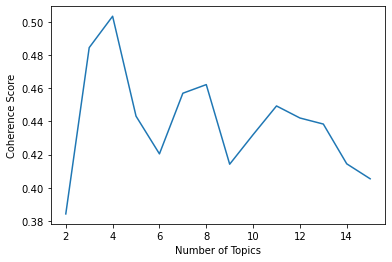

In [14]:
# Looks like the optimal number of topics is 4 according to a c_v coherence score
x_values = range(2, 16)
plt.plot(x_values, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show();

In [15]:
# trying coherence values with u_mass instead of c_v as the coherence score
def compute_coherence_values_2(corpus, lda_dict, texts, min_n_topics, max_n_topics):
    '''
    Compute coherence values for different LDA models with different numbers of topics
    
    Parameters:
    ----------
    lda_dict: Gensim dictionary
    corpus: Gensim corpus
    texts: list of input texts
    min_n_topics: minimum number of topics
    max_n_topics: maximum number of topics
    
    Returns:
    -------
    model_list: List of LDA models with varying number of topics
    coherence_values: Coherence values corresponding to eachh LDA model
    topic_list: List of words belonging to each topic
    '''
    
    model_list = []
    coherence_values = []
    topic_list = []
    
    for n_topics in range(min_n_topics, max_n_topics + 1):
        lda_model = LdaModel(corpus = corpus,
                                  id2word=lda_dict,
                                  num_topics=n_topics,
                                  random_state=100,
                                  update_every=1,
                                  chunksize=50,
                                  passes=10,
                                  alpha='auto',
                                  per_word_topics=True)
        topic_list.append(lda_model.print_topics())
        
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=lda_dict, coherence='u_mass')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values, topic_list

In [ ]:
model_list_2, coherence_values_2, topic_list_2 = compute_coherence_values_2(corpus=corpus, lda_dict=lda_dictionary,
                                                                            texts = tokenize_text, min_n_topics=2, max_n_topics=15)

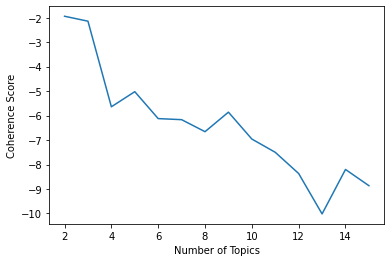

In [17]:
# Looks like the optimal number of topics is 2 or 5 according to U-mass coherence score
x_values = range(2, 16)
plt.plot(x_values, coherence_values_2)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show();

Coherence score is defined as the average or median of the pairwise word similarity scores of the words within a topic. In other words, it scores a single topic by looking at the degree of semantic similarity between high scoring words in the topic. If you see the same keywords being repeated in multiple topics, that means your topics overlap too much and that's bad.

After looking at each of my LDA models, in the end, I decided to narrow down my number of topics to 6. The c_v score shows that around 4 topics had a high coherence score, but there I noticed in the PyLDA visual that 6 topics also had good separation of topics without too much overlap. Additionally, I prefer having more topics rather than fewer topics. However, having more than 7 topics resulted in lots of overlap according to my pyLDA topic visualization.<br/>

I think I'm ready to build my final LDA model with 6 topics.

###### Trying out Corex Topic Modeling
[Corex](https://github.com/gregversteeg/corex_topic) is a good way to see topic especially if you want to see certain topics
anchored to certain words. It supports topic modeling for a sparse matrix and for a large dataset.

In [20]:
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

In [62]:
def corex_cleaning_function(text, regex_patterns, char_space, char_no_space, abbrev_dict):
    '''
    Inputs:
    - text (string): string of reddit posts
    - regex_patterns (list): list of regex patterns to remove
    - char_space (string): characters to replace with a space
    - char_no_space (string): characters to replace with no space
    - abbrev_dict (dict): dictionary to replace abbreviations with full words
    Outputs:
    - cleaned_text (string): cleaned string of reddit posts
    ''' 
    
    cleaned_text = text
    
    for pattern in regex_patterns:
        cleaned_text = re.sub(pattern, ' ', cleaned_text)
    
    for char in char_space:
        cleaned_text = cleaned_text.replace(char, ' ')
    
    for char in char_no_space:
        cleaned_text = cleaned_text.replace(char, '')
        
    for key in abbrev_dict.keys():
        cleaned_text = cleaned_text.replace(key, ' ' + abbrev_dict[key] + ' ')
    
    cleaned_text = cleaned_text.lower()
    
    return cleaned_text

In [43]:
def corex_pos_function(text, pos_filter, spacy_nlp):
    '''
    Filter text based on part of speech using spacy
    
    Parameters:
    - text (string): text to filter on
    - pos_filter (list): list of parts of speech to filter on; based on spacy part of speech tagging
    
    Output:
    - Returns a string where each word in the string has been filtered for part of speech
    '''
       
    doc = spacy_nlp(str(text))
    pos_word_list = []    
        
    for token in doc:
        for part_of_speech in pos_filter:
            # if the text is a specific part of speech and is greater than length 2 to avoid short words
            if token.pos_ == part_of_speech and len(token.text) > 2:
                pos_word_list.append(token.text)
              
    pos_words = ' '.join(pos_word_list)
 
    return pos_words

In [47]:
regex_patterns = ['\n', '\t', r'https?:\/\/\S+', r'&\S*', r'\xa0', r'[__]{2,}', r'[\d]+', 'χ', '®']
char_space = '^*>|[]()",°#.:%?'
char_no_space = '/-\\'
abbrev_dict = {"MD": "doctor_of_medicine",
               "MPH": "master_of_public_health",
               "MBA": "master_of_business_administrationi",
               "NP": "nurse_practitioner",
               "PA": "physician_assistant",
               "RN": "registered_nurse",
               "DVM": "doctor_of_veterinary_medicine",
               "DDS": "doctor_of_dentistry",
               "DO": "doctor_of_osteopathy",
               "ICU": "intensive_care_unit",
               "ER": "emergency_room",
               "ED": "emergency_department",
               "EMS": "emergency_medical_services",
               "EMR": "electronic_medical_records",
               "CFR": "case_fatality_rate",
               "CT": "computed_tomography",
               "CDC": "centers_for_disease_control",
               "WHO": "world_health_organization",
               "FDA": "food_and_drug_administration",
               "SARS": "severe_acute_respiratory_syndrome",
               "MERS": "middle_east_respiratory_syndrome",
               "ARDS": "acute_respiratory_distress_syndrome",
               "SOM": "school_of_medicine",
               "COVID": "covid", # make sure the word covid is distinct
               "N95": "n_ninety_fifty", # make sure n-95 masks are distinct words
               "PPE": "personal_protective_equipment"
               }

In [63]:
corex_df = reddit_df.copy()
spacy_nlp = spacy.load("en_core_web_sm")
corex_df["cleaned_text"] = corex_df["full_text"].apply(lambda x: corex_cleaning_function(x, regex_patterns, char_space, char_no_space, abbrev_dict))
corex_df["nouns"] = corex_df["cleaned_text"].apply(lambda x: corex_pos_function(x, ["NOUN"], spacy_nlp))
corex_df.head()

,post_id,author,created_utc,month,title,submission_text,score,num_comments,stickied,url,full_text,cleaned_text,nouns
0,ff8hns,mcgianni,1583647410,3,"Testimony of a surgeon working in Bergamo, in ...",«In one of the non-stop e-mails that I receive...,1,571,False,https://www.reddit.com/r/medicine/comments/ff8...,"Testimony of a surgeon working in Bergamo, in ...",testimony of a surgeon working in bergamo in ...,testimony surgeon heart emails hospital admini...
1,figd1n,indianola,1584181842,3,I posted a while back seeking a clinical portr...,Got this being passed around my circle of phys...,1,393,False,https://www.reddit.com/r/medicine/comments/fig...,I posted a while back seeking a clinical portr...,i posted a while back seeking a clinical portr...,while portrait one today staff circle physicia...
2,fg2rze,Light151,1583791324,3,Anyone else have colleagues who are still sayi...,I have been trying to raise awareness that our...,1,386,False,https://www.reddit.com/r/medicine/comments/fg2...,Anyone else have colleagues who are still sayi...,anyone else have colleagues who are still sayi...,colleagues flu awareness hospital system thing...
3,fi78id,dyingalonewithcats,1584135092,3,Latest CDC updates: best case/worst case scena...,,1,336,False,https://www.reddit.com/r/medicine/comments/fi7...,Latest CDC updates: best case/worst case scena...,latest centers_for_disease_control updates ...,case scenarios
4,fdznn0,half-taught-wrong,1583433075,3,[Serious] What is your plan if you or someone ...,I am trying to learn from medical colleagues. ...,1,322,False,https://www.reddit.com/r/medicine/comments/fdz...,[Serious] What is your plan if you or someone ...,serious what is your plan if you or someone ...,plan family colleagues reddit session web pane...


In [66]:
# prep data for corex
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.7, ngram_range=(2,3), stop_words='english')
doc_word = tfidf_vectorizer.fit_transform(corex_df["cleaned_text"])
vectorized_words = list(np.asarray(tfidf_vectorizer.get_feature_names()))

In [67]:
# n_hidden is number of topics
topic_model = ct.Corex(n_hidden=6, words=vectorized_words, seed=1)
topic_model.fit(doc_word, words=vectorized_words, docs=corex_df["cleaned_text"])

corex_topics = topic_model.get_topics()
for i, topic in enumerate(corex_topics):
    topic_words, _ = zip(*topic)
    print(f'Topic {str(i+1)}: ' + ', '.join(topic_words))

Topic 1: weekly careers thread, weekly careers, careers thread, specialty practicing, specialty practicing physicians, posted outside, practicing physicians wondering, careers thread continue, career specialty practicing, thread continue
Topic 2: severe_acute_respiratory_syndrome cov, postexposure prophylaxis, cancer detection, breast cancer detection, radiation exposure, severe_acute_respiratory_syndrome cov infection, cov infection, hydroxychloroquine postexposure prophylaxis, hydroxychloroquine postexposure, viral load
Topic 3: health officials, public health officials, free time, thought id, chest pain, work hopefully, half dozen, rapid response, web doctor_of_medicine, healthcare plan
Topic 4: independent practice, sound like, nurse_practitioner physician_assistant, residency spots, physician shortage, drug companies, whats deal, students residents, stem cell, sure im
Topic 5: expert witness, med mal, years med school, years med, mal case, med mal case, hot spots, epic ehr, witnes

###### Analysis of Corex
The 6 topics don't look good. Topic 6 for example has "bread butter" as a topic bigram. The first topic is very repetitive and includes a lot of weekly career threads. I'm happier with my LDA topic modeling than my Corex topic modeling.

<a id='section5'></a>

### 5. Topic Modeling by Month

I've finalized my topic model: LDA with 6 topics. Now that I have a final LDA topic model, I want to see the distribution of topics per month and analyze sentiment per topic per month.

In [15]:
# for my cleaning function
regex_patterns = ['\n', '\t', r'https?:\/\/\S+', r'&\S*', r'\xa0', r'[__]{2,}', r'[\d]+', 'χ', '®']
char_space = '^*>|[]()",°#.:%?'
char_no_space = '/-\\'
abbrev_dict = {"MD": "doctor_of_medicine",
               "MPH": "master_of_public_health",
               "MBA": "master_of_business_administrationi",
               "NP": "nurse_practitioner",
               "PA": "physician_assistant",
               "RN": "registered_nurse",
               "DVM": "doctor_of_veterinary_medicine",
               "DDS": "doctor_of_dentistry",
               "DO": "doctor_of_osteopathy",
               "ICU": "intensive_care_unit",
               "ER": "emergency_room",
               "ED": "emergency_department",
               "EMS": "emergency_medical_services",
               "EMR": "electronic_medical_records",
               "CFR": "case_fatality_rate",
               "CT": "computed_tomography",
               "CDC": "centers_for_disease_control",
               "WHO": "world_health_organization",
               "FDA": "food_and_drug_administration",
               "SARS": "severe_acute_respiratory_syndrome",
               "MERS": "middle_east_respiratory_syndrome",
               "ARDS": "acute_respiratory_distress_syndrome",
               "SOM": "school_of_medicine",
               "COVID": "covid", # make sure the word covid is distinct
               "N95": "n_ninety_fifty", # make sure n-95 masks are distinct words
               "PPE": "personal_protective_equipment"
               }

# for my part of speech filter
my_pos_filter = ["NOUN", "PROPN"]

In [16]:
# doing LDA. I cannot use my PreProcessor class because the inputs for LDA are different
spacy_nlp = spacy.load("en_core_web_sm")
cleaned_text = my_cleaning_function(reddit_df["full_text"], regex_patterns, char_space, char_no_space, abbrev_dict)
cleaned_text = my_pos_function(cleaned_text, my_pos_filter, spacy_nlp)

tokenize_text = []
stop_words = stopwords.words('english')

for post in cleaned_text:
    tokenize_post = word_tokenize(post)
    tokenize_post = [word for word in tokenize_post if word not in stop_words]
    tokenize_text.append(tokenize_post)

In [17]:
lda_dictionary = corpora.Dictionary(tokenize_text)
corpus = [lda_dictionary.doc2bow(text) for text in tokenize_text]

In [18]:
# final model is LDA with 6 topics
final_lda_model = LdaModel(corpus=corpus,
                            id2word=lda_dictionary,
                            num_topics=6,
                            random_state=100,
                            update_every=1,
                            chunksize=50,
                            passes=10,
                            alpha='auto',
                            per_word_topics=True)
pprint(final_lda_model.print_topics())

[(0,
  '0.028*"patients" + 0.023*"hospital" + 0.018*"time" + 0.018*"people" + '
  '0.015*"patient" + 0.014*"day" + 0.010*"doctor" + 0.010*"doctors" + '
  '0.009*"hours" + 0.009*"medicine"'),
 (1,
  '0.011*"evidence" + 0.010*"results" + 0.009*"approach" + 0.007*"california" '
  '+ 0.007*"insight" + 0.007*"regeneration" + 0.006*"retinopathy" + '
  '0.006*"spine" + 0.006*"visit" + 0.006*"route"'),
 (2,
  '0.028*"physician" + 0.026*"physician_assistant" + 0.026*"physicians" + '
  '0.022*"practice" + 0.020*"training" + 0.018*"school" + 0.018*"year" + '
  '0.017*"doctor_of_medicine" + 0.017*"medicine" + 0.015*"residency"'),
 (3,
  '0.025*"patients" + 0.015*"use" + 0.013*"risk" + '
  '0.013*"severe_acute_respiratory_syndrome" + 0.012*"coronavirus" + '
  '0.011*"disease" + 0.010*"clinic" + 0.010*"post" + 0.009*"masks" + '
  '0.008*"covid"'),
 (4,
  '0.030*"patient" + 0.019*"infection" + 0.016*"cov" + 0.013*"dose" + '
  '0.010*"blood" + 0.009*"computed_tomography" + 0.009*"hours" + 0.009*"serum

In [20]:
# Final pyLDA visualization
final_vis = pyLDAvis.gensim.prepare(final_lda_model, corpus, lda_dictionary)
pyLDAvis.display(final_vis)

Now that I have my final topic model, I want to look at the topics assigned to each reddit post. What are the dominant posts per topic according to my final model?

In [19]:
def get_topics(dataframe, ldamodel, lda_dictionary):
    '''
    With this function, I use the ldamodel to assign topics to each post in the dataframe
    
    Parameters:
    ----------
    - dataframe (Dataframe): dataframe with reddit posts
    - ldamodel (LDA model): the trained LDA model that can assign topic probabilities
    - lda_dictionary: the LDA dictionary
    
    Returns:
    -------
    - topic_df (Dataframe): dataframe with reddit posts and the dominant topic per post
    
    '''
    # store topics in a dataframe
    topic_df = pd.DataFrame()
    
    copy_df = dataframe.copy()
    copy_df["cleaned_text"] = copy_df["full_text"].apply(lambda x: monthly_cleaning_function(x, regex_patterns, char_space, char_no_space, abbrev_dict))
    copy_df["tokenized_test"] = copy_df["cleaned_text"].apply(lambda x: word_tokenize(x))
    
    corpus = [lda_dictionary.doc2bow(text) for text in copy_df["tokenized_test"].to_list()]
    final_topics = [ldamodel.get_document_topics(text) for text in corpus]
    
    for i, post in enumerate(final_topics):
        post = sorted(post, key=lambda x: x[1], reverse=True)
        
        for j, (topic_num, topic_prob) in enumerate(post):
            if j == 0: # the dominant topic is in the 0th index
                keywords = ldamodel.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, _ in keywords])
                topic_df = topic_df.append(pd.Series([int(topic_num + 1), round(topic_prob, 4), topic_keywords]), ignore_index=True)
            else:
                break
    topic_df.columns = ["dominant_topic", "perc_contribution", "topic_keywords"]
    
    topic_df = pd.concat([topic_df, copy_df["full_text"]], axis=1)
    topic_df = pd.concat([topic_df, copy_df["cleaned_text"]], axis=1)
    topic_df = pd.concat([topic_df, copy_df["month"]], axis=1)
    topic_df["dominant_topic"] = topic_df["dominant_topic"].astype(int)
    
    return topic_df  

Create a topic Dataframe to look at the dominant topic per reddit post.

In [23]:
topic_df = get_topics(reddit_df, final_lda_model, lda_dictionary)
topic_df.head()

,dominant_topic,perc_contribution,topic_keywords,full_text,cleaned_text,month
0,1,0.6190,"patients, hospital, time, people, patient, day...","Testimony of a surgeon working in Bergamo, in ...",testimony of a surgeon working in bergamo in ...,3
1,5,0.4994,"patient, infection, cov, dose, blood, computed...",I posted a while back seeking a clinical portr...,i posted a while back seeking a clinical portr...,3
2,4,0.3974,"patients, use, risk, severe_acute_respiratory_...",Anyone else have colleagues who are still sayi...,anyone else have colleagues who are still sayi...,3
3,4,0.3988,"patients, use, risk, severe_acute_respiratory_...",Latest CDC updates: best case/worst case scena...,latest centers_for_disease_control updates ...,3
4,1,0.6501,"patients, hospital, time, people, patient, day...",[Serious] What is your plan if you or someone ...,serious what is your plan if you or someone ...,3


Map the topic from an integer back to my self-labeled topics.

In [ ]:
topic_dict = {1: "Work",
              2: "Medical Studies",
              3: "School & Training",
              4: "Coronavirus Precautions",
              5: "Coronavirus Treatment",
              6: "Healthcare System"
             }
topic_df["topic"] = topic_df["dominant_topic"].map(topic_dict)
topic_df.head()

In [56]:
# Get a topic document matrix
def get_topic_matrix(dataframe, ldamodel, lda_dictionary):
    '''
    With this function, I use the ldamodel to assign topic probabilites to each post. I look at all the 
    possible topic probabilities per post rather than just the top topic probability.
    
    Parameters:
    ----------
    - dataframe (Dataframe): dataframe with reddit posts
    - ldamodel (LDA model): the trained LDA model that can assign topic probabilities
    - lda_dictionary: the LDA dictionary
    
    Returns:
    -------
    - topic_df (Dataframe): dataframe with reddit posts and all topic probabilities for each post
    
    '''
    topic_matrix_df = pd.DataFrame()
    
    copy_df = dataframe.copy()
    copy_df["cleaned_text"] = copy_df["full_text"].apply(lambda x: monthly_cleaning_function(x, regex_patterns, char_space, char_no_space, abbrev_dict))
    copy_df["tokenized_test"] = copy_df["cleaned_text"].apply(lambda x: word_tokenize(x))
    
    corpus = [lda_dictionary.doc2bow(text) for text in copy_df["tokenized_test"].to_list()]
    final_topics = [ldamodel.get_document_topics(text) for text in corpus]
    
    
    for i, post in enumerate(final_topics):
        post = sorted(post, key=lambda x: x[1], reverse=True)
        store_topics = []
        
        for j, (topic_num, topic_prob) in enumerate(post):
            store_topics.append(int(topic_num + 1))
            store_topics.append(round(topic_prob, 4))
        
        topic_matrix_df = topic_matrix_df.append(pd.Series(store_topics), ignore_index=True)

    topic_matrix_df.columns = ["1st_topic", "1st_topic_perc", "2nd_topic", "2nd_topic_perc",
                               "3rd_topic", "3rd_topic_perc", "4th_topic", "4th_topic_perc",
                               "5th_topic", "5th_topic_perc", "6th_topic", "6th_topic_perc"
                              ]
    
    topic_matrix_df = pd.concat([topic_matrix_df, copy_df["full_text"]], axis=1)
    topic_matrix_df = pd.concat([topic_matrix_df, copy_df["cleaned_text"]], axis=1)
    topic_matrix_df = pd.concat([topic_matrix_df, copy_df["month"]], axis=1)
    
    topic_matrix_df["1st_topic"] = topic_matrix_df["1st_topic"].astype(int)
    topic_matrix_df["2nd_topic"] = topic_matrix_df["2nd_topic"].astype(int)
    topic_matrix_df["3rd_topic"] = topic_matrix_df["3rd_topic"].astype(int)
    topic_matrix_df["4th_topic"] = topic_matrix_df["4th_topic"].astype(int)
    
    topic_matrix_df["5th_topic"] = topic_matrix_df["5th_topic"].fillna(0)
    topic_matrix_df["5th_topic"] = topic_matrix_df["5th_topic"].astype(int)
    
    topic_matrix_df["6th_topic"] = topic_matrix_df["6th_topic"].fillna(0)
    topic_matrix_df["6th_topic"] = topic_matrix_df["6th_topic"].astype(int)
    
    return topic_matrix_df 

In [57]:
topic_matrix_df = get_topic_matrix(reddit_df, final_lda_model, lda_dictionary)
topic_matrix_df.head()

,1st_topic,1st_topic_perc,2nd_topic,2nd_topic_perc,3rd_topic,3rd_topic_perc,4th_topic,4th_topic_perc,5th_topic,5th_topic_perc,6th_topic,6th_topic_perc,full_text,cleaned_text,month
0,1,0.6190,4,0.1544,5,0.1273,6,0.0472,3,0.0422,0,NaN,"Testimony of a surgeon working in Bergamo, in ...",testimony of a surgeon working in bergamo in ...,3
1,5,0.4994,1,0.1907,6,0.1433,4,0.0791,3,0.0652,2,0.0222,I posted a while back seeking a clinical portr...,i posted a while back seeking a clinical portr...,3
2,4,0.3974,1,0.3570,5,0.0844,3,0.0679,6,0.0511,2,0.0421,Anyone else have colleagues who are still sayi...,anyone else have colleagues who are still sayi...,3
3,4,0.3988,1,0.2520,3,0.2080,6,0.0804,5,0.0407,2,0.0201,Latest CDC updates: best case/worst case scena...,latest centers_for_disease_control updates ...,3
4,1,0.6501,3,0.1048,4,0.1011,2,0.0771,6,0.0572,0,NaN,[Serious] What is your plan if you or someone ...,serious what is your plan if you or someone ...,3


In [ ]:
topic_dict = {1: "Work",
              2: "Medical Studies",
              3: "School & Training",
              4: "Coronavirus Precautions",
              5: "Coronavirus Treatment",
              6: "Healthcare System"
             }

In [60]:
topic_matrix_df["1st_topic_mapped"] = topic_matrix_df["1st_topic"].map(topic_dict)
topic_matrix_df.head()

,1st_topic,1st_topic_perc,2nd_topic,2nd_topic_perc,3rd_topic,3rd_topic_perc,4th_topic,4th_topic_perc,5th_topic,5th_topic_perc,6th_topic,6th_topic_perc,full_text,cleaned_text,month,1st_topic_mapped
0,1,0.6190,4,0.1544,5,0.1273,6,0.0472,3,0.0422,0,NaN,"Testimony of a surgeon working in Bergamo, in ...",testimony of a surgeon working in bergamo in ...,3,Medical Studies
1,5,0.4994,1,0.1907,6,0.1433,4,0.0791,3,0.0652,2,0.0222,I posted a while back seeking a clinical portr...,i posted a while back seeking a clinical portr...,3,Healthcare System
2,4,0.3974,1,0.3570,5,0.0844,3,0.0679,6,0.0511,2,0.0421,Anyone else have colleagues who are still sayi...,anyone else have colleagues who are still sayi...,3,Coronavirus Treatment
3,4,0.3988,1,0.2520,3,0.2080,6,0.0804,5,0.0407,2,0.0201,Latest CDC updates: best case/worst case scena...,latest centers_for_disease_control updates ...,3,Coronavirus Treatment
4,1,0.6501,3,0.1048,4,0.1011,2,0.0771,6,0.0572,0,NaN,[Serious] What is your plan if you or someone ...,serious what is your plan if you or someone ...,3,Medical Studies


In [62]:
# save to a pickle file for future reference
topic_matrix_df.to_pickle("data/topic_matrix_df.pkl")

In [23]:
# what are the dominant topics per month?
topic_by_month = (topic_df
                   .groupby(["month", "dominant_topic"])
                   .size()
                  )
topic_by_month = topic_by_month.to_frame(name = "post_count").reset_index()
topic_by_month.head(10)

,month,dominant_topic,post_count
0,1,1,89
1,1,2,8
2,1,3,30
3,1,4,30
4,1,5,17
5,1,6,25
6,2,1,88
7,2,2,8
8,2,3,31
9,2,4,25


In [24]:
def calculate_topic_perc(row, dataframe):
    '''
    How many posts per month are associated with each topic? For example, out of all the posts in January, how many
    of them were associated with coronavirus related topics?
    
    Parameters:
    ----------
    - row (Series): row of a dataframe
    - dataframe (Dataframe): dataframe of reddit posts
    
    Returns:
    -------
    a number corresponding to the percentage of that topic per row.
    
    '''
    # Calculate the number of posts per topic per month
    post_count = row["post_count"]
    month = row["month"]
    
    # Calculate the number of posts made per month
    total_month_posts = dataframe[dataframe["month"] == month]["post_count"].sum()
    
    return round((post_count / total_month_posts), 2)
    

In [27]:
topic_by_month["topic_percent"] = topic_by_month.apply(calculate_topic_perc, dataframe=topic_by_month, axis=1)
topic_by_month.head(30)

,month,dominant_topic,post_count,topic_percent
0,1,1,89,0.45
1,1,2,8,0.04
2,1,3,30,0.15
3,1,4,30,0.15
4,1,5,17,0.09
5,1,6,25,0.13
6,2,1,88,0.44
7,2,2,8,0.04
8,2,3,31,0.16
9,2,4,25,0.13


In [29]:
# if topic is 1, I want a list of all the topic_percent by month
topic_by_month[topic_by_month["dominant_topic"] == 1]["topic_percent"].to_list()

[0.45, 0.44, 0.46, 0.52, 0.39, 0.44, 0.49]

In [30]:
topic_by_month.groupby("month").agg(list)

,dominant_topic,post_count,topic_percent
month,,,
1,"[1, 2, 3, 4, 5, 6]","[89, 8, 30, 30, 17, 25]","[0.45, 0.04, 0.15, 0.15, 0.09, 0.13]"
2,"[1, 2, 3, 4, 5, 6]","[88, 8, 31, 25, 11, 36]","[0.44, 0.04, 0.16, 0.13, 0.06, 0.18]"
3,"[1, 2, 3, 4, 5, 6]","[83, 4, 17, 45, 7, 23]","[0.46, 0.02, 0.09, 0.25, 0.04, 0.13]"
4,"[1, 2, 3, 4, 5, 6]","[96, 6, 29, 19, 6, 27]","[0.52, 0.03, 0.16, 0.1, 0.03, 0.15]"
5,"[1, 2, 3, 4, 5, 6]","[77, 3, 53, 23, 19, 20]","[0.39, 0.02, 0.27, 0.12, 0.1, 0.1]"
6,"[1, 2, 3, 4, 5, 6]","[87, 5, 32, 33, 17, 24]","[0.44, 0.03, 0.16, 0.17, 0.09, 0.12]"
7,"[1, 2, 3, 4, 5, 6]","[96, 9, 28, 28, 8, 27]","[0.49, 0.05, 0.14, 0.14, 0.04, 0.14]"


Onto visualizations! What percent of posts are related to which topics and how has this changed over time?

In [75]:
color_list = ["#d56969", "#ffabab", "#d39c9c", "#a6d3b8", "#50a772", "#2d5c3f"]

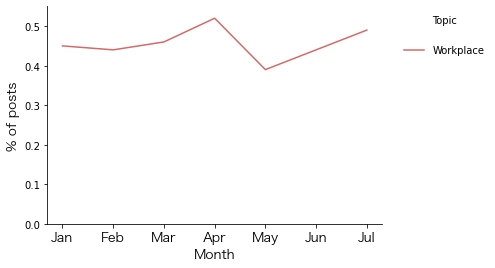

In [100]:
fig, ax = plt.subplots()

sns.lineplot(x="month", y="topic_percent", hue="dominant_topic", data=topic_by_month, hue_order = [1], palette=[color_list[0]])
sns.despine(top=True, right=True)

plt.ylim((0, 0.55))
plt.xlabel("Month", fontname="Hiragino Sans GB", fontsize=13)
plt.ylabel("% of posts", fontname="Hiragino Sans GB", fontsize=13)
plt.xticks(ticks=[1,2,3,4,5,6,7], labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul"], fontname="Hiragino Sans GB", fontsize=13)

legend = ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon=False)
legend.set_title("Topic")
legend.texts[0].set_text("")
legend.texts[1].set_text("Workplace")
plt.savefig(f'images/workplace_topic.png', format='png', dpi=600, transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight');

In [90]:
color_list_array = np.array(color_list)
second_colors = list(color_list_array[[0, 2, 4]])

['#d56969', '#d39c9c', '#50a772']

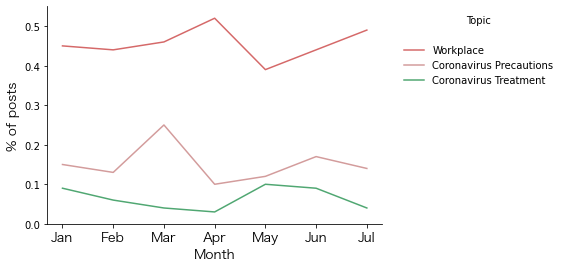

In [99]:
fig, ax = plt.subplots()
color_list_array = np.array(color_list)

sns.lineplot(x="month", y="topic_percent", hue="dominant_topic", data=topic_by_month, hue_order = [1, 4, 5], palette=second_colors)
sns.despine(top=True, right=True)

plt.ylim((0, 0.55))
plt.xlabel("Month", fontname="Hiragino Sans GB", fontsize=13)
plt.ylabel("% of posts", fontname="Hiragino Sans GB", fontsize=13)
plt.xticks(ticks=[1,2,3,4,5,6,7], labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul"], fontname="Hiragino Sans GB", fontsize=13)

legend = ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon=False)
legend.set_title("Topic")
legend.texts[0].set_text("")
legend.texts[1].set_text("Workplace")
legend.texts[2].set_text("Coronavirus Precautions")
legend.texts[3].set_text("Coronavirus Treatment")
plt.savefig(f'images/workplace_covid_topic.png', format='png', dpi=600, transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight');

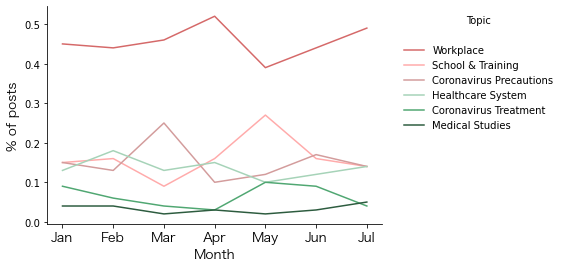

In [101]:
fig, ax = plt.subplots()

sns.lineplot(x="month", y="topic_percent", hue="dominant_topic", data=topic_by_month, hue_order = [1, 3, 4, 6, 5, 2], palette=color_list)
sns.despine(top=True, right=True)

plt.xlabel("Month", fontname="Hiragino Sans GB", fontsize=13)
plt.ylabel("% of posts", fontname="Hiragino Sans GB", fontsize=13)
plt.xticks(ticks=[1,2,3,4,5,6,7], labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul"], fontname="Hiragino Sans GB", fontsize=13)

legend = ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon=False)
legend.set_title("Topic")
legend.texts[0].set_text("")
legend.texts[1].set_text("Workplace")
legend.texts[2].set_text("School & Training")
legend.texts[3].set_text("Coronavirus Precautions")
legend.texts[4].set_text("Healthcare System")
legend.texts[5].set_text("Coronavirus Treatment")
legend.texts[6].set_text("Medical Studies")
plt.savefig(f'images/all_topics.png', format='png', dpi=600, transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight');

<a id='section6'></a>

### 6. Sentiment Analysis by Topic

How does sentiment vary per topic? Do the coronavirus related topics have lower sentiment?

In [64]:
analyzer = SentimentIntensityAnalyzer()
topic_df["compound_sentiment"] = topic_df["full_text"].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [65]:
topic_df["textblob_polarity"] = topic_df["full_text"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [67]:
sentiment_df = (topic_df
                .groupby(["month"], as_index=False)[["compound_sentiment", "textblob_polarity"]]
                .agg({"compound_sentiment": "mean", "textblob_polarity": "mean"})
               )
sentiment_df

,month,compound_sentiment,textblob_polarity
0,1,0.126615,0.065354
1,2,0.159389,0.083976
2,3,0.052913,0.060493
3,4,0.050180,0.046809
4,5,0.079672,0.077292
5,6,0.058399,0.044668
6,7,0.137868,0.075602


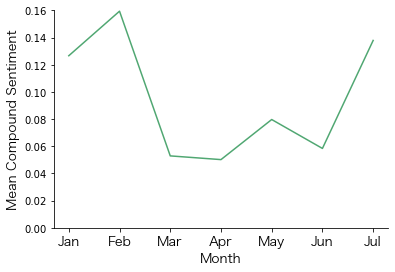

In [97]:
# looking at mean compound sentiment over time using Vader Sentiment
sns.lineplot(x=sentiment_df["month"], y=sentiment_df["compound_sentiment"], color="#50a772")
sns.despine(top=True, right=True)

plt.xlabel("Month", fontname="Hiragino Sans GB", fontsize=13)
plt.ylabel("Mean Compound Sentiment", fontname="Hiragino Sans GB", fontsize=13)
plt.ylim((0, 0.16))

plt.xticks(ticks=[1,2,3,4,5,6,7], labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul"], fontname="Hiragino Sans GB", fontsize=13);
plt.savefig(f'images/sentiment_over_time.png', format='png', dpi=600, transparent=True);

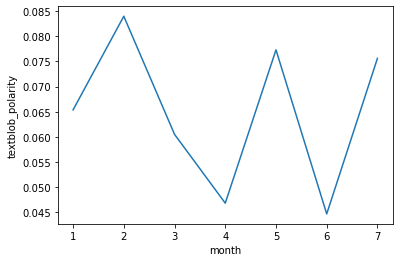

In [169]:
# looking at mean compound sentiment over time using TextBlob Sentiment
sns.lineplot(x=sentiment_df["month"], y=sentiment_df["textblob_polarity"]);

Plotting sentiment by topic. The graph is pretty ugly, so I'll include this in the appendix of my presentation.

In [89]:
color_list = ["#d56969", "#ffabab", "#d39c9c", "#a6d3b8", "#50a772", "#2d5c3f"]

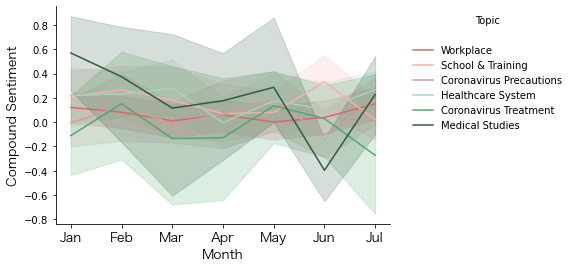

In [95]:
fig, ax = plt.subplots()

sns.lineplot(x="month", y="compound_sentiment", hue="dominant_topic", data=topic_df, hue_order = [1, 3, 4, 6, 5, 2], palette=color_list)
sns.despine(top=True, right=True)

plt.xlabel("Month", fontname="Hiragino Sans GB", fontsize=13)
plt.ylabel("Compound Sentiment", fontname="Hiragino Sans GB", fontsize=13)
plt.xticks(ticks=[1,2,3,4,5,6,7], labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul"], fontname="Hiragino Sans GB", fontsize=13)

legend = ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon=False)
legend.set_title("Topic")
legend.texts[0].set_text("")
legend.texts[1].set_text("Workplace")
legend.texts[2].set_text("School & Training")
legend.texts[3].set_text("Coronavirus Precautions")
legend.texts[4].set_text("Healthcare System")
legend.texts[5].set_text("Coronavirus Treatment")
legend.texts[6].set_text("Medical Studies")
plt.savefig(f'images/topic_sentiment.png', format='png', dpi=600, transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight');

Now, I want to try plotting compound sentiment over each month and seeing if there are certain months that have more posts with negative
sentiment than positive sentiment.

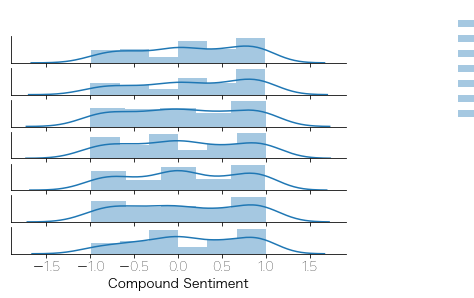

In [142]:
# these plots aren't looking to great; will try using Tableau
fig, ax = plt.subplots(7, 1, sharex=True)

sns.despine(top=True, right=True)

jan_sentiment = sns.distplot(a=topic_df[topic_df["month"] == 1]["compound_sentiment"], ax=ax[0], label="Jan")
jan_sentiment.set(yticks=[])

feb_sentiment = sns.distplot(topic_df[topic_df["month"] == 2]["compound_sentiment"], ax=ax[1], label="Feb")
feb_sentiment.set(yticks=[])

mar_sentiment = sns.distplot(topic_df[topic_df["month"] == 3]["compound_sentiment"], ax=ax[2], label="Mar")
mar_sentiment.set(yticks=[])

apr_sentiment = sns.distplot(topic_df[topic_df["month"] == 4]["compound_sentiment"], ax=ax[3], label="Apr")
apr_sentiment.set(yticks=[])

may_sentiment = sns.distplot(topic_df[topic_df["month"] == 5]["compound_sentiment"], ax=ax[4], label="May")
may_sentiment.set(yticks=[])

jun_sentiment = sns.distplot(topic_df[topic_df["month"] == 6]["compound_sentiment"], ax=ax[5], label="Jun")
jun_sentiment.set(yticks=[])

jul_sentiment = sns.distplot(topic_df[topic_df["month"] == 7]["compound_sentiment"], ax=ax[6], label="Jul")
jul_sentiment.set(yticks=[])

fig.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon=False)
plt.xlabel("Compound Sentiment", fontname="Hiragino Sans GB", fontsize=13)
plt.xticks(fontname="Hiragino Sans", fontsize=13);

Yikes! This graph isn't pretty and is hard to interpret. I'm not going to use this visualization in my presentation, and I can't really discern any good information from this.

In [80]:
new_topic_df = pd.concat([topic_df, reddit_df[["title", "url"]]], axis=1)
new_topic_df.head()

,dominant_topic,perc_contribution,topic_keywords,full_text,cleaned_text,month,topic,compound_sentiment,textblob_polarity,title,url
0,1,0.6190,"patients, hospital, time, people, patient, day...","Testimony of a surgeon working in Bergamo, in ...",testimony of a surgeon working in bergamo in ...,3,Work,-0.9994,0.020421,"Testimony of a surgeon working in Bergamo, in ...",https://www.reddit.com/r/medicine/comments/ff8...
1,5,0.4994,"patient, infection, cov, dose, blood, computed...",I posted a while back seeking a clinical portr...,i posted a while back seeking a clinical portr...,3,Coronavirus Treatment,-0.9888,0.007025,I posted a while back seeking a clinical portr...,https://www.reddit.com/r/medicine/comments/fig...
2,4,0.3974,"patients, use, risk, severe_acute_respiratory_...",Anyone else have colleagues who are still sayi...,anyone else have colleagues who are still sayi...,3,Coronavirus Precautions,-0.9003,-0.136111,Anyone else have colleagues who are still sayi...,https://www.reddit.com/r/medicine/comments/fg2...
3,4,0.3988,"patients, use, risk, severe_acute_respiratory_...",Latest CDC updates: best case/worst case scena...,latest centers_for_disease_control updates ...,3,Coronavirus Precautions,0.6369,0.750000,Latest CDC updates: best case/worst case scena...,https://www.reddit.com/r/medicine/comments/fi7...
4,1,0.6501,"patients, hospital, time, people, patient, day...",[Serious] What is your plan if you or someone ...,serious what is your plan if you or someone ...,3,Work,-0.9434,0.074918,[Serious] What is your plan if you or someone ...,https://www.reddit.com/r/medicine/comments/fdz...


In [81]:
# want to use this data in Tableau; take a sample of 250 posts rather than all 1300+ posts
sample_df = new_topic_df.sample(n=250)
sample_df.head()

,dominant_topic,perc_contribution,topic_keywords,full_text,cleaned_text,month,topic,compound_sentiment,textblob_polarity,title,url
484,3,0.3261,"physician, physician_assistant, physicians, pr...",Florida blocks medical examiners over COVID de...,florida blocks medical examiners over covid ...,5,School & Training,-0.7003,0.000000,Florida blocks medical examiners over COVID de...,https://www.reddit.com/r/medicine/comments/gbf...
671,3,0.5948,"physician, physician_assistant, physicians, pr...",From Florida Medical Association. The Speaker ...,from florida medical association the speaker ...,1,School & Training,0.9752,0.010824,From Florida Medical Association.,https://www.reddit.com/r/medicine/comments/epc...
856,1,0.4469,"patients, hospital, time, people, patient, day...",EMS here - just wanted to say thank you to the...,emergency_medical_services here just wanted...,6,Work,0.9422,0.258333,EMS here - just wanted to say thank you to the...,https://www.reddit.com/r/medicine/comments/hda...
128,1,0.6363,"patients, hospital, time, people, patient, day...",Are coronavirus tests readily available to doc...,are coronavirus tests readily available to doc...,3,Work,-0.3736,0.400000,Are coronavirus tests readily available to doc...,https://www.reddit.com/r/medicine/comments/fg1...
781,6,0.4023,"health, healthcare, care, doctors, data, syste...",Are there ways to document police brutality in...,are there ways to document police brutality in...,6,Healthcare System,-0.9697,0.058333,Are there ways to document police brutality in...,https://www.reddit.com/r/medicine/comments/gv7...


In [83]:
# save as a CSV for tableau
sample_df[["title", "url", "topic", "compound_sentiment", "textblob_polarity"]].to_csv("data/topic_sentiment_.csv")